# Importy

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
import time
import torch
from torch_geometric.data import Data, Batch
import pytorch_lightning as pl
import numpy as np
import pandas as pd
from torch.nn import (
    BatchNorm1d,
    Identity
)
import torch.nn.functional as F
from torch_geometric.nn import (
    GATConv,
    GCNConv,
    global_mean_pool
)
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

from config.config import RnaquanetConfig
from config.os import change_dir
from network.rnaqa_lightning import RnaQALightning
from data.ares_data_module import AresDataModule

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Konfiguracja

In [7]:
change_dir('../..')
config = RnaquanetConfig('config.yml')
torch.set_float32_matmul_precision('high')

# Dane

In [8]:
data = AresDataModule(config, batch_size=1000, num_workers=1)
data.prepare_data()

# Sieć neuronowa

In [9]:
class SimpleGraphRegression(pl.LightningModule):
    def __init__(self, hidden_dim, batch_norm = False):
        super(SimpleGraphRegression, self).__init__()
        
        self.batch_norm1 = BatchNorm1d(96) if batch_norm else Identity()
        self.conv1 = GATConv(96, hidden_dim, dropout=0.5)
        self.batch_norm2 = BatchNorm1d(hidden_dim) if batch_norm else Identity()
        self.conv2 = GCNConv(hidden_dim, int(1.5*hidden_dim))
        self.batch_norm3 = BatchNorm1d(int(1.5*hidden_dim)) if batch_norm else Identity()
        self.conv3 = GATConv(int(1.5*hidden_dim), 2*hidden_dim, dropout=0.2)
        self.batch_norm4 = BatchNorm1d(2*hidden_dim) if batch_norm else Identity()
        self.conv4 = GCNConv(2*hidden_dim, 1)
        
    def forward(self, x, edge_index, edge_attr, batch):
        x = self.batch_norm1(x)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        
        x = self.batch_norm2(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.batch_norm3(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = self.batch_norm4(x)
        x = self.conv4(x, edge_index)
        
        x = global_mean_pool(x, batch) 
        
        return x
    
    def training_step(self, item, batch_idx):
        x = item.x
        edge_index = item.edge_index
        edge_attr = item.edge_attr
        batch = item.batch
        y = item.y.view(-1, 1)
        output = self(x, edge_index, edge_attr, batch)
        loss = F.mse_loss(output, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, batch_size=len(batch))
        return loss
    
    def validation_step(self, item, batch_idx):
        x = item.x
        edge_index = item.edge_index
        edge_attr = item.edge_attr
        batch = item.batch
        y = item.y.view(-1, 1)
        output = self(x, edge_index, edge_attr, batch)
        loss = F.mse_loss(output, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, batch_size=len(batch))
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.3)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]

In [10]:
class LossLogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss_epoch' in trainer.logged_metrics:
            self.train_losses.append(trainer.logged_metrics['train_loss_epoch'].item())
        self.on_train_end(trainer, pl_module)

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.logged_metrics:
            self.val_losses.append(trainer.logged_metrics['val_loss'].item())
            
    def lol_on_train_end(self, trainer, pl_module):
        epochs = range(1, len(self.train_losses) + 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        
        # Znajdź minimalny train_loss i val_loss
        min_train_loss = min(self.train_losses)
        min_val_loss = min(self.val_losses)
        
        # Zaznacz punkt z minimalnym train_loss
        plt.scatter(self.train_losses.index(min_train_loss) + 1, min_train_loss, color='red', label=f'{min_train_loss:.2f}')
        # Zaznacz punkt z minimalnym val_loss
        plt.scatter(self.val_losses.index(min_val_loss), min_val_loss, color='green', label=f'{min_val_loss:.2f}')
        plt.yscale('log')
        plt.legend()
        plt.show()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params
--------------------------------------------
0 | batch_norm1 | BatchNorm1d | 192   
1 | conv1       | GATConv     | 6.3 K 
2 | batch_norm2 | BatchNorm1d | 128   
3 | conv2       | GCNConv     | 6.2 K 
4 | batch_norm3 | BatchNorm1d | 192   
5 | conv3       | GATConv     | 12.7 K
6 | batch_norm4 | BatchNorm1d | 256   
7 | conv4       | GCNConv     | 129   
--------------------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.105     Total estimated model params size (MB)


Epoch 39: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s, v_num=87, train_loss_step=2.510, val_loss=4.570, train_loss_epoch=2.470]


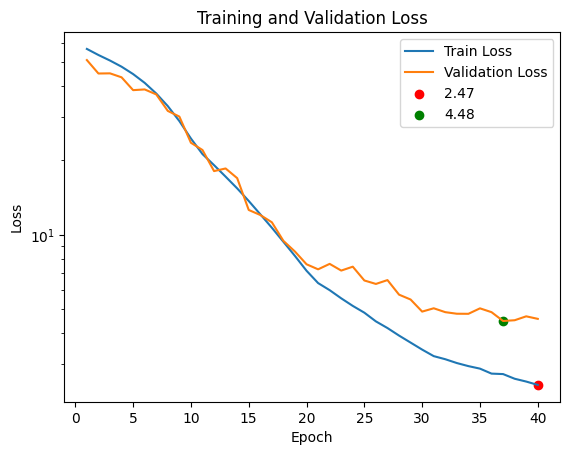

In [12]:
data.batch_size = 1000
model = SimpleGraphRegression(hidden_dim=64, batch_norm=True)
logger = LossLogger()
trainer = pl.Trainer(max_epochs=50, log_every_n_steps=1, callbacks=[
    logger,
    EarlyStopping('val_loss'),
    ModelCheckpoint(dirpath='/', save_top_k=1, monitor='val_loss')
]) 
trainer.fit(model, data)
logger.lol_on_train_end(None, None)

In [ ]:
trainer.save_checkpoint('model.ckpt')

In [ ]:
target = []
myresult = []
with torch.no_grad():
    val_dataloader = data.test_dataloader()
    for item in val_dataloader:

        x = item.x
        edge_index = item.edge_index
        edge_attr = item.edge_attr
        batch = item.batch
        y = item.y.view(-1, 1)
        output = model(x, edge_index, edge_attr, batch)

        target += item.y.ravel().tolist()
        myresult += output.ravel().tolist()
pd.DataFrame({'rms': myresult, 'target': target}).to_csv('plik.csv', index=False)